(C) 2025 Gerold Baier, University College London

# Two Nonlinear Two-Population Oscillators with Perturbation
## Model

The two populations' temporal dynamics (change of state) is described by two first-order nonlinear differential equations. Here we have two coupled units:

$$ \frac{dEx_1}{dt}      = (h_{ex}      - Ex_1    - c_2*sigmoid(In_1) + c_{EE}*sigmoid((Ex_1 + 
frac_E*Ex_2))  + pert)*\tau_{ex}$$
$$ \frac{dIn_1}{dt} \,\, = (h_{in} \,\, - In_1 \, - c_4*sigmoid(In_1) + c_{EI}*sigmoid((Ex_1 + 
frac_I*Ex_2)))*\tau_{in}$$

$$ \frac{dEx_2}{dt}      = (h_{ex}      - Ex_2    - c_2*sigmoid(In_2) + c_{EE}*sigmoid((Ex_2 + 
frac_E*Ex_1)))*\tau_{ex}$$
$$ \frac{dIn_2}{dt} \,\, = (h_{in} \,\, - In_2 \, - c_4*sigmoid(In_2) + c_{EI}*sigmoid((Ex_2 + 
frac_I*Ex_1)))*\tau_{in}$$

$Ex_i$ and $In_i$ are variables that change with time $t$ and represent the excitatory and inhibitory population, respectively.

$h_{ex}$ and $h_{in}$ are constant inputs to the populations. 

$c_2$ and $c_4$ are model parameters representing internal inhibitory coupling. 

$\tau_{ex}$ and $\tau_{in}$ are the poulation time constants.

$c_{EE}$ and $c_{EI}$ are self- and between population excitatory coupling parameters.

_pert_ represents external perturbation.

Function _sigmoid_ is a continuous step function, conmputationally implemented as tangens hyperbolicus.


In [1]:
from scipy.integrate import odeint

from numpy import tanh, mod, linspace, around, zeros, mod, asarray
from numpy import sin, pi, var, ndarray, flip, arange, sign

from numpy.random import default_rng, seed

from matplotlib.pyplot import subplots

import sk_dsp_comm.sigsys as ss

from scipy.signal import find_peaks

from itertools import product


# Functions

In [2]:
def sigmoid(u):
    return tanh(u)

def oscillator(y, t, N, h_ex, h_in, pars, frac_E, frac_I, sr, time_stop, pert):
               
    tau_ex, tau_in, c2, c4, c_EE, c_EI = pars

    if len(pert) == 0:

        dydt = (

        
            (h_ex - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid(y[0]+frac_E*y[2]))*tau_ex,
             
            (h_in - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid(y[0]+frac_I*y[2]))*tau_in,

             
            (h_ex - y[2] - c2*sigmoid(y[3]) + c_EE*sigmoid(y[2]+frac_E*y[0]))*tau_ex,
            
            (h_in - y[3] - c4*sigmoid(y[3]) + c_EI*sigmoid(y[2]+frac_I*y[0]))*tau_in
           )
        
        return dydt


    else:

        time_index = int(t*sr)

        if time_index >= time_stop*sr:

            dydt = zeros(2*N)

            return dydt


        else:
            
            dydt = (

                (pert[time_index] - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid(y[0]+frac_E*y[2]))*tau_ex,
                 
                (h_in             - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid(y[0]+frac_I*y[2]))*tau_in,

                 
                (h_ex             - y[2] - c2*sigmoid(y[3]) + c_EE*sigmoid(y[2]+frac_E*y[0]))*tau_ex,
                
                (h_in             - y[3] - c4*sigmoid(y[3]) + c_EI*sigmoid(y[2]+frac_I*y[0]))*tau_in
               )

            return dydt


def plot_bifdiagram_scan(results, freq_set):

    if freq_set[-1] < freq_set[0]:
        
        freq_set = flip(freq_set)

    freq_min, freq_max = freq_set[0], freq_set[-1]

    fig, ax  = subplots(nrows=1, figsize=(5, 4))

    for result in results:
    
        results_min_f, results_max_f = result[0], result[1] 
      
        for xe, ye in zip(freq_set, results_max_f[0]):
    
            if not isinstance(ye, ndarray):
                ax.scatter(xe, ye, c='k', s=5)
            else:
                ax.scatter([xe] * len(ye), ye, c='r', s=5, marker='o')
    
        for xe, ye in zip(freq_set, results_min_f[0]):
    
            if not isinstance(ye, ndarray):
                ax.scatter(xe, ye, c='k', s=5)
            else:
                ax.scatter([xe] * len(ye), ye, c='b', s=5, marker='x')
    
        ax.set_xticks(linspace(freq_min, freq_max, 5));
        ax.set_xticklabels([]);
    
        ax.set_ylabel('Ex', fontsize=14)
    
        y_min, y_max = ax.get_ylim()

        # y_min, y_max = 0.5, 1.5

        ax.set_ylim(y_min, y_max)
        ax.set_yticks(linspace(y_min, y_max, 3))
        ax.set_yticklabels(around(linspace(y_min, y_max, 3)), fontsize=12)

    ax.set_xticks(linspace(freq_min, freq_max, 5));
    ax.set_xticklabels(around(linspace(freq_min, freq_max, 5), 2), fontsize=12);
    
    ax.set_xlabel('Parameter', fontsize=16)

    fig.tight_layout()
    
    return fig, ax


def plot_bifdiagram(results_min_f, results_max_f, 
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots(figsize=(6, 4))

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='D')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='k', marker='D')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='d')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='gray', marker='d')


    ax.set_xticks(linspace(par_set[0], par_set[-1], 5));
    ax.set_xticklabels(around(linspace(par_set[0], par_set[-1], 5), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('EX', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);

    fig.tight_layout()
    
    return fig, ax

# Time Series

End of run: [ -1.9  -13.72  -1.9  -13.72]



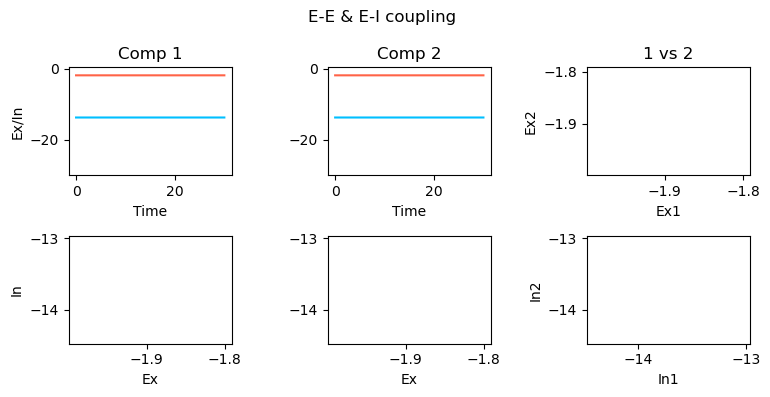

In [63]:
N = 2

# Input parameter
h_ex_0 = -7.0
h_in_0 = -4.0

# Oscillator parameters
pars = (1, 2.5, 10, 0, 5, 10) # Homoclinic
# pars = (1, 1.5, 10, 0, 5, 10) # SNIC
# t_ex, t_in, c2, c4, cc_EE, cc_EI

# Strong synchronisation
# frac_E, frac_I = 0.5, 0.0 # < 0, 0 means no coupling

# Temporary desynchronisation
# frac_E, frac_I = 0.0, 0.5 # 0, 0 means no coupling

frac_E, frac_I = 0.2, 0.12 # < 0, 0 means no coupling

# Initial conditions
SEED = 123
rng  = default_rng(SEED)
# y_ini = rng.uniform(size=2*N)

# Time array
time_stop = 30
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

pulse = []

# Simulation
y = odeint(func=oscillator, y0=y_ini, t=time, 
          args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
          hmax=0.1)

# Resetting of initial conditions
y_ini = y[-1, :]

# Show final values of all variables
print('End of run:', around(y[-1,:],2))
print('')


fig, ax = subplots(ncols=3, nrows=2, figsize=(8, 4))

ax[0, 0].plot(time, y[:,0], color='tomato');
ax[0, 0].plot(time, y[:,1], color='deepskyblue');
ax[0, 1].plot(time, y[:,2], color='tomato');
ax[0, 1].plot(time, y[:,3], color='deepskyblue');

ax[1, 0].plot(y[:, 0], y[:, 1], color='m');
ax[1, 1].plot(y[:,2], y[:,3], color='violet');

ax[0, 2].plot(y[:,0], y[:,2], color='orangered');
ax[1, 2].plot(y[:,1], y[:,3], color='cornflowerblue');

ax[0, 0].set_xlabel('Time')
ax[0, 1].set_xlabel('Time')
ax[0, 0].set_ylabel('Ex/In')
ax[1, 0].set_xlabel('Ex')
ax[1, 0].set_ylabel('In')
ax[1, 1].set_xlabel('Ex')
ax[0, 2].set_xlabel('Ex1')
ax[0, 2].set_ylabel('Ex2')
ax[1, 2].set_xlabel('In1')
ax[1, 2].set_ylabel('In2')

ax[0, 0].set_title('Comp 1')
ax[0, 1].set_title('Comp 2')
ax[0, 2].set_title('1 vs 2')

y_min, y_max = y.min(), y.max()
ax[0, 0].set_ylim(y_min*(1-0.1*(y_max-y_min)*sign(y_min)), y_max*(1+0.1*(y_max-y_min)*sign(y_max)))
ax[0, 1].set_ylim(y_min*(1-0.1*(y_max-y_min)*sign(y_min)), y_max*(1+0.1*(y_max-y_min)*sign(y_max)))


if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I coupling'
    fig.suptitle(chars)

elif frac_E > 0 and frac_I > 0:
    
    chars = 'E-E & E-I coupling'
    fig.suptitle(chars)

else:
    
    chars = 'No coupling'
    fig.suptitle(chars)
    
fig.tight_layout()


# Bifurcation Diagram h_ex

In [13]:
# Bifurcation parameter set
steps = 20

par_min, par_max = -6.8, -7.2
par_min, par_max = -7.2, -6.8

par_set = linspace(par_min, par_max, steps)

# Time array
time_stop = 500
time = linspace(start=0, stop=time_stop, num=time_stop*sr)

results_min_f      = dict()
results_min_inds_f = dict()
results_max_f      = dict()
results_max_inds_f = dict()

rows = time.size

pulse = []

# Simulation "forward"
for par in par_set:
      
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, par, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
                  hmax=0.1)

    for num, series in enumerate(y_pert[rows//2:,:-1:2].T):
                
        if var(series) < 0.0001:
    
            if num not in results_min_f:
                
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
               
            else:
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)    

            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
               
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    

        else:
            
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_min_f:

                results_min_f[num]      = [y_f_mins]
                results_min_inds_f[num] = [y_f_min_inds]
                
                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]

            else:

                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)
                
                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)


    if par != par_set[-1]:
        
        y_ini = y_pert[-1, :]

print('')
print('Scan complete!', list(around(y_pert[-1,:],3)))
print('')


Scan complete! [np.float64(-0.774), np.float64(-6.532), np.float64(-0.107), np.float64(-1.063)]



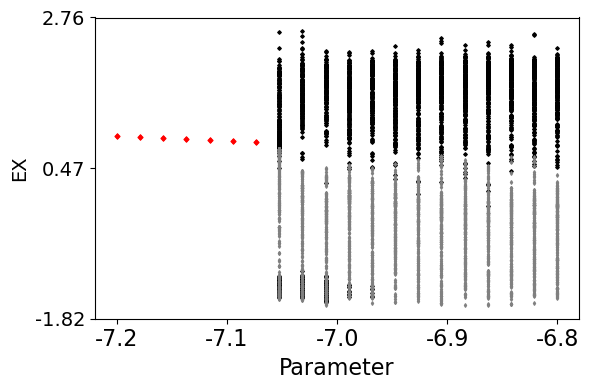

In [14]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


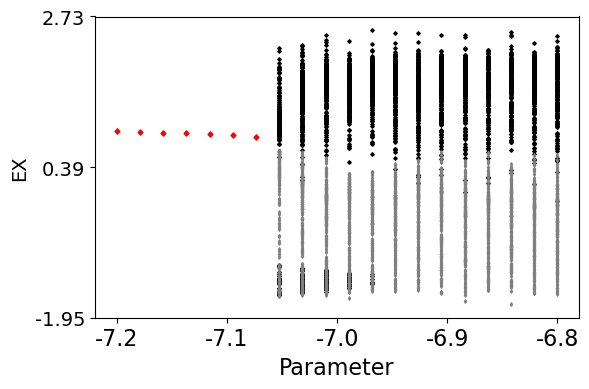

In [12]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


# Bifurcation Diagram coup_EE

In [27]:
h_ex_0 = -6.8

# Bifurcation parameter set
steps = 10

par_min, par_max = 0., 0.2

par_set = linspace(par_min, par_max, steps)

# Time array
time_stop = 500
time = linspace(start=0, stop=time_stop, num=time_stop*sr)

results_min_f      = dict()
results_min_inds_f = dict()
results_max_f      = dict()
results_max_inds_f = dict()

rows = time.size

pulse = []

# Simulation "forward"
for par in par_set:
      
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, h_ex_0, h_in_0, pars, par, frac_I, sr, time_stop, pulse), 
                  hmax=0.1)

    for num, series in enumerate(y_pert[rows//2:,:-1:2].T):
                
        if var(series) < 0.0001:
    
            if num not in results_min_f:
                
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
               
            else:
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)    

            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
               
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    

        else:
            
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_min_f:

                results_min_f[num]      = [y_f_mins]
                results_min_inds_f[num] = [y_f_min_inds]
                
                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]

            else:

                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)
                
                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)


    if par != par_set[-1]:
        
        y_ini = y_pert[-1, :]

print('')
print('Scan complete!', list(around(y_pert[-1,:],3)))
print('')


Scan complete! [np.float64(0.974), np.float64(-5.029), np.float64(0.974), np.float64(-5.029)]



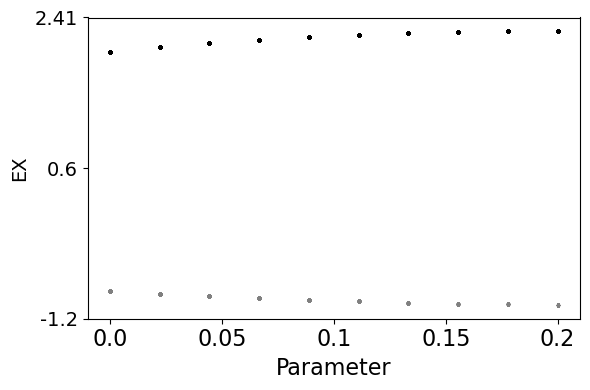

In [28]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


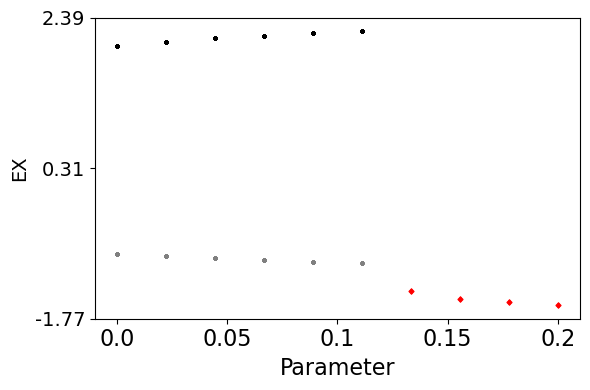

In [24]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


# Pulse Perturbation Example Series

End of run: [ -1.9  -13.72  -1.9  -13.72]



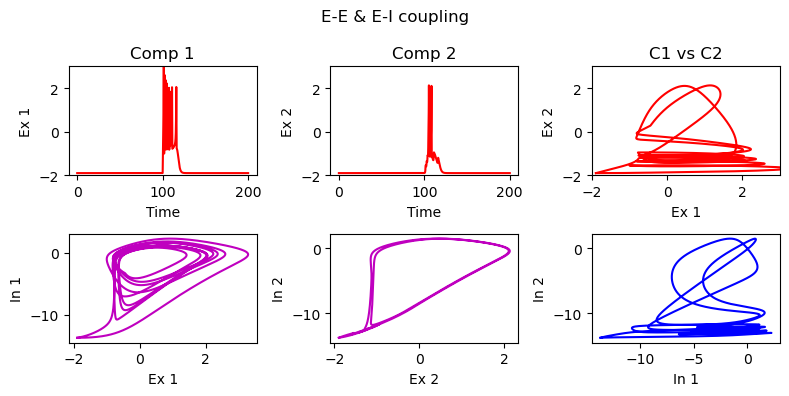

In [126]:
# h_ex_0 = -7.06
# frac_E, frac_I = 0.5, 0.0 # < 1. 0 means no coupling

pulse_wid = 5.
pulse_amp = 2.5
pulse_per = 200

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
# y_in = rng.uniform(size=2*N)

# Time array
time_stop = 200
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2-pulse_wid/2, pulse_wid)
    
# Simulation
y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
              args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
              hmax=0.1)

y_medium = y_pert.copy()

# Resetting of initial conditions
# y_in = y_pert[-1, :]

# Show final values of all variables
print('End of run:', around(y_pert[-1,:],2))
print('')

fig, ax = subplots(ncols=3, nrows=2, figsize=(8, 4))

ax[0, 0].plot(time, y_pert[:,0], color='r');
ax[0, 1].plot(time, y_pert[:,2], color='r');

ax[1, 0].plot(y_pert[:,0], y_pert[:,1], color='m');
ax[1, 1].plot(y_pert[:,2], y_pert[:,3], color='m');

ax[0, 2].plot(y_pert[:,0], y_pert[:,2], color='r');
ax[1, 2].plot(y_pert[:,1], y_pert[:,3], color='b');


ax[0, 0].set_title('Comp 1')
ax[0, 1].set_title('Comp 2')
ax[0, 2].set_title('C1 vs C2')

ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Ex 1')
ax[1, 0].set_xlabel('Ex 1')
ax[1, 0].set_ylabel('In 1')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Ex 2')
ax[1, 1].set_xlabel('Ex 2')
ax[1, 1].set_ylabel('In 2')

ax[0, 2].set_xlabel('Ex 1')
ax[0, 2].set_ylabel('Ex 2')
ax[1, 2].set_xlabel('In 1')
ax[1, 2].set_ylabel('In 2')


ax[0, 0].set_ylim(-2, 3)
ax[0, 1].set_ylim(-2, 3)
ax[0, 2].set_xlim(-2, 3)
ax[0, 2].set_ylim(-2, 3)



if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I coupling'
    fig.suptitle(chars)

elif frac_E > 0 and frac_I > 0:
    
    chars = 'E-E & E-I coupling'
    fig.suptitle(chars)

else:
    
    chars = 'No coupling'
    fig.suptitle(chars)
    
fig.tight_layout()

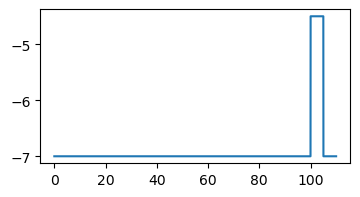

In [127]:
fig, ax = subplots(figsize=(4, 2))

ax.plot(time[:110000], pert[:110000]);

# Distance Metrics

In [128]:
import numpy as np
from scipy.spatial.distance import euclidean

def path_length(trajectory):
    """Calculate the total path length of a trajectory"""
    displacements = np.linalg.norm(np.diff(trajectory, axis=0), axis=1)
    return np.sum(displacements)

def trajectory_difference_path_based(trajectory_data):
    """
    Compare trajectories based on their actual path characteristics
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # 1. Path length difference
    path1_length = path_length(osc1_traj)
    path2_length = path_length(osc2_traj)
    path_length_diff = abs(path1_length - path2_length)
    
    # 2. Area between paths (integrated distance)
    distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    area_between = np.trapz(distances, dx=1)
    
    # 3. Dynamic differences (velocity/orientation)
    vel1 = np.diff(osc1_traj, axis=0)
    vel2 = np.diff(osc2_traj, axis=0)
    
    # Cosine similarity of velocities (how aligned are movements)
    dot_products = np.sum(vel1 * vel2, axis=1)
    norms_product = np.linalg.norm(vel1, axis=1) * np.linalg.norm(vel2, axis=1)
    cosine_similarities = dot_products / (norms_product + 1e-10)  # avoid division by zero
    avg_alignment = np.mean(cosine_similarities)
    
    return {
        'path_length_difference': path_length_diff,
        'area_between_paths': area_between,
        'velocity_alignment': avg_alignment,
        'composite_measure': path_length_diff + area_between + (1 - avg_alignment)
    }

def dtw_distance(a, b):
    """Simple DTW implementation"""
    n, m = len(a), len(b)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                         dtw_matrix[i, j-1],    # deletion  
                                         dtw_matrix[i-1, j-1])  # match
    
    return dtw_matrix[n, m]

def trajectory_difference_dtw(trajectory_data):
    """
    Use DTW to handle trajectories that are similar but phase-shifted
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # Apply DTW to each dimension separately
    dtw_x = dtw_distance(osc1_traj[:, 0], osc2_traj[:, 0])
    dtw_y = dtw_distance(osc1_traj[:, 1], osc2_traj[:, 1])
    
    # Combined DTW distance
    combined_dtw = np.sqrt(dtw_x**2 + dtw_y**2)
    
    return combined_dtw

def trajectory_shape_difference(trajectory_data):
    """
    Compare the shape characteristics of trajectories
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # Calculate curvature for each trajectory
    def calculate_curvature(traj):
        dx_dt = np.gradient(traj[:, 0])
        dy_dt = np.gradient(traj[:, 1])
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)
        
        curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2 + 1e-10)**1.5
        return curvature
    
    curvature1 = calculate_curvature(osc1_traj)
    curvature2 = calculate_curvature(osc2_traj)
    
    # Compare curvature profiles
    curvature_diff = np.mean(np.abs(curvature1 - curvature2))
    
    # Compare turning points (local maxima in curvature)
    from scipy.signal import find_peaks
    peaks1, _ = find_peaks(curvature1, height=np.mean(curvature1))
    peaks2, _ = find_peaks(curvature2, height=np.mean(curvature2))
    
    turning_point_diff = abs(len(peaks1) - len(peaks2))
    
    return curvature_diff + turning_point_diff

def comprehensive_trajectory_analysis(trajectory_data):
    """
    Comprehensive analysis that should distinguish different path types
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    results = {}
    
    # Basic point-wise distances (your original approach)
    point_distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    results['max_point_distance'] = np.max(point_distances)
    results['mean_point_distance'] = np.mean(point_distances)
    results['area_between'] = np.trapezoid(point_distances, dx=1)
    
    # Path-based measures
    results['path_length_osc1'] = path_length(osc1_traj)
    results['path_length_osc2'] = path_length(osc2_traj)
    results['path_length_difference'] = abs(results['path_length_osc1'] - results['path_length_osc2'])
    
    # Dynamic measures
    vel1 = np.diff(osc1_traj, axis=0)
    vel2 = np.diff(osc2_traj, axis=0)
    
    velocity_correlations = []
    for i in range(len(vel1)):
        if np.linalg.norm(vel1[i]) > 0 and np.linalg.norm(vel2[i]) > 0:
            cos_sim = np.dot(vel1[i], vel2[i]) / (np.linalg.norm(vel1[i]) * np.linalg.norm(vel2[i]))
            velocity_correlations.append(cos_sim)
    
    results['velocity_correlation'] = np.mean(velocity_correlations) if velocity_correlations else 0
    
    # Shape-based measure
    results['shape_difference'] = trajectory_shape_difference(trajectory_data)
    
    # Create a single composite score
    results['composite_score'] = (
        results['area_between'] + 
        results['path_length_difference'] + 
        (1 - results['velocity_correlation']) +
        results['shape_difference']
    )
    
    return results


result_similar = comprehensive_trajectory_analysis(y_similar[105000:120000, :])

result_different = comprehensive_trajectory_analysis(y_different[105000:120000, :])

result_medium = comprehensive_trajectory_analysis(y_medium[105000:120000, :])

print("Similar trajectories:", result_similar['composite_score'])
print("Different trajectories:", result_different['composite_score'])
print("Medium trajectories:", result_medium['composite_score'])


Similar trajectories: 8624.300107775958
Different trajectories: 24771.765353695973
Medium trajectories: 54975.10050609993


In [118]:
result_similar

{'max_point_distance': np.float64(5.289331091709366),
 'mean_point_distance': np.float64(0.5749351955355837),
 'area_between': np.float64(8622.315682854667),
 'path_length_osc1': np.float64(36.908308037977434),
 'path_length_osc2': np.float64(35.12698331057021),
 'path_length_difference': np.float64(1.781324727407224),
 'velocity_correlation': np.float64(0.9730216308729599),
 'shape_difference': np.float64(0.17612182475539645),
 'composite_score': np.float64(8624.300107775958)}

In [143]:
list(result_similar.keys())

['max_point_distance',
 'mean_point_distance',
 'area_between',
 'path_length_osc1',
 'path_length_osc2',
 'path_length_difference',
 'velocity_correlation',
 'shape_difference',
 'composite_score']

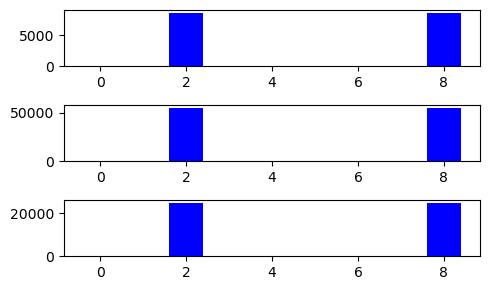

In [149]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 3))

for index, r_dict in enumerate([result_similar, result_medium, result_different]):
    
    measures = [r_dict[measure] for measure in r_dict]
    
    labels   = list(r_dict.keys())
    
    bars = ax[index].bar(arange(len(labels)), measures, color='b')


fig.tight_layout()

# for index, metric in enumerate(measures):
#         values = [results_dict1[metric], results_dict2[metric]]
#         bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    #         axes[i].set_title(metric.replace('_', ' ').title())
    #         axes[i].set_ylabel('Value')
            
    #         # Add value labels on bars
    #         for bar, value in zip(bars, values):
    #             axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
    #                        f'{value:.3f}', ha='center', va='bottom')
 

__________
max_point_distance 5.289331091709366
path_length_osc1 36.908308037977434
path_length_difference 1.781324727407224
__________
max_point_distance 13.598744112711696
path_length_osc1 108.33047455847603
path_length_difference 51.09572825599655
__________
max_point_distance 14.194335028482477
path_length_osc1 30.64491737091397
path_length_difference 29.11068048468865


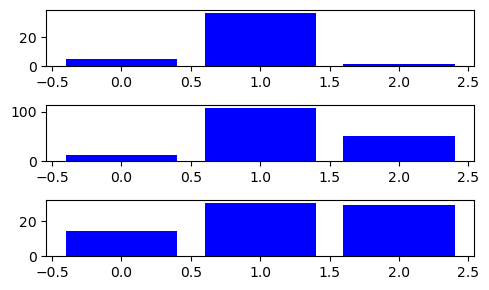

In [169]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 3))

measures_all = list()

for ind_1, r_dict in enumerate([result_similar, result_medium, result_different]):

    print('_'*10)

    measures = list()
    labels   = list()
        
    for ind_2, key in enumerate(r_dict):

        if ind_2 in [0, 3, 5]:

            print(key, r_dict[key])

            measures.append(r_dict[key])
            labels.append(key)
        
    bars = ax[ind_1].bar(arange(len(labels)), measures, color='b')

    measures_all.append(measures)


fig.tight_layout()

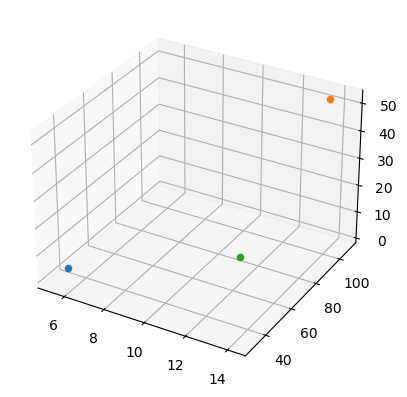

In [168]:
from matplotlib.pyplot import figure

fig = figure()
ax = fig.add_subplot(projection='3d')

for index in arange(3):
    
    ax.scatter(*measures_all[index]);

In [167]:
measures_all[index]

[np.float64(5.289331091709366),
 np.float64(36.908308037977434),
 np.float64(1.781324727407224)]

In [ ]:
from matplotlib.pyplot import figure

    
    

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def extract_measures(trajectory_data):
    """
    Extract the three measures from a trajectory
    """
    # Reuse the functions from our previous analysis
    results = comprehensive_trajectory_analysis(trajectory_data)
    
    max_dist = results['max_point_distance']
    path_diff = results['path_length_difference']
    shape_diff = results['shape_difference']
    
    return [max_dist, path_diff, shape_diff]

# Alternative: Individual functions if you want them separate
def max_point_distance(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    return np.max(distances)

def path_length_difference(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    def path_length(traj):
        displacements = np.linalg.norm(np.diff(traj, axis=0), axis=1)
        return np.sum(displacements)
    
    path1 = path_length(osc1_traj)
    path2 = path_length(osc2_traj)
    return abs(path1 - path2)

def shape_difference(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    def calculate_curvature(traj):
        dx_dt = np.gradient(traj[:, 0])
        dy_dt = np.gradient(traj[:, 1])
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)
        
        curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2 + 1e-10)**1.5
        return curvature
    
    curvature1 = calculate_curvature(osc1_traj)
    curvature2 = calculate_curvature(osc2_traj)
    
    from scipy.signal import find_peaks
    peaks1, _ = find_peaks(curvature1, height=np.mean(curvature1))
    peaks2, _ = find_peaks(curvature2, height=np.mean(curvature2))
    
    curvature_diff = np.mean(np.abs(curvature1 - curvature2))
    turning_point_diff = abs(len(peaks1) - len(peaks2))
    
    return curvature_diff + turning_point_diff

def plot_3d_trajectory_clusters(trajectories, labels=None, colors=None):
    """
    Create a 3D scatter plot of trajectory measures
    
    Parameters:
    trajectories: list of numpy arrays, each shape (samples, 4)
    labels: optional list of labels for each trajectory
    colors: optional list of colors for each trajectory
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # If no colors provided, use a colormap
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    elif len(colors) != len(trajectories):
        colors = [colors[0]] * len(trajectories)  # Use first color for all
    
    # Collect all measures for axis limits
    all_measures = []
    
    for index, trajectory in enumerate(trajectories):
        # Calculate the three measures
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            shape_difference(trajectory)
        ]
        
        all_measures.append(measures)
        
        # Create label
        if labels is not None and index < len(labels):
            label = labels[index]
        else:
            label = f'Traj {index+1}'
        
        # Plot the point
        ax.scatter(*measures, 
                  c=[colors[index]], 
                  s=100, 
                  label=label,
                  alpha=0.7,
                  edgecolors='w',
                  linewidth=0.5)
    
    all_measures = np.array(all_measures)
    
    # Set labels and title
    ax.set_xlabel('Max Point Distance', fontsize=12, labelpad=10)
    ax.set_ylabel('Path Length Difference', fontsize=12, labelpad=10)
    ax.set_zlabel('Shape Difference', fontsize=12, labelpad=10)
    ax.set_title('3D Trajectory Clustering', fontsize=14, fontweight='bold', pad=20)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust viewing angle for better visualization
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    return all_measures

# Enhanced version with clustering visualization
def plot_3d_trajectory_clusters_enhanced(trajectories, group_labels=None, cluster_colors=None):
    """
    Enhanced version with better grouping and visualization
    """
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for different groups
    if cluster_colors is None:
        cluster_colors = plt.cm.Set1(np.linspace(0, 1, len(set(group_labels)) if group_labels else 1))
    
    all_measures = []
    
    for index, trajectory in enumerate(trajectories):
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            shape_difference(trajectory)
        ]
        all_measures.append(measures)
        
        # Determine color and label based on grouping
        if group_labels and index < len(group_labels):
            group_idx = group_labels[index]
            color = cluster_colors[group_idx]
            label = f'Group {group_idx}' if index == 0 or group_labels[index-1] != group_idx else ""
        else:
            color = 'blue'
            label = f'Traj {index+1}'
        
        ax.scatter(*measures, 
                  c=[color], 
                  s=100, 
                  label=label,
                  alpha=0.7,
                  edgecolors='w',
                  linewidth=1)
    
    all_measures = np.array(all_measures)
    
    # Set labels with units if known
    ax.set_xlabel('Max Distance\n(larger = more separation)', fontsize=11, labelpad=10)
    ax.set_ylabel('Path Length Diff\n(larger = different path lengths)', fontsize=11, labelpad=10)
    ax.set_zlabel('Shape Difference\n(larger = different shapes)', fontsize=11, labelpad=10)
    ax.set_title('3D Trajectory Measure Space\n(Cluster Analysis)', fontsize=14, fontweight='bold', pad=20)
    
    # Add grid and improve layout
    ax.grid(True, alpha=0.3)
    
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
              bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # Multiple viewing angles
    print("Plotting from multiple angles...")
    angles = [(30, 45), (20, 135), (10, 225)]
    
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)
        plt.draw()
        plt.pause(0.5)  # Brief pause to see different angles
    
    plt.tight_layout()
    plt.show()
    
    return all_measures

# Simple version following your pseudocode exactly
def simple_3d_plot(trajectory):
    """
    Simple version following your pseudocode exactly
    """
 
    for index, trajectory in enumerate(trajectories):
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            max_point_distance(trajectory)
        ]
        
        ax.scatter(*measures, s=80, alpha=0.7, label=f'Traj {index+1}')
    
    ax.set_xlabel('Max Point Distance')
    ax.set_ylabel('Path Length Difference')
    ax.set_zlabel('Shape Difference')
    ax.set_title('3D Trajectory Measures')
    ax.legend()
    
    plt.show()


# 3D Scatter of trajectories measures

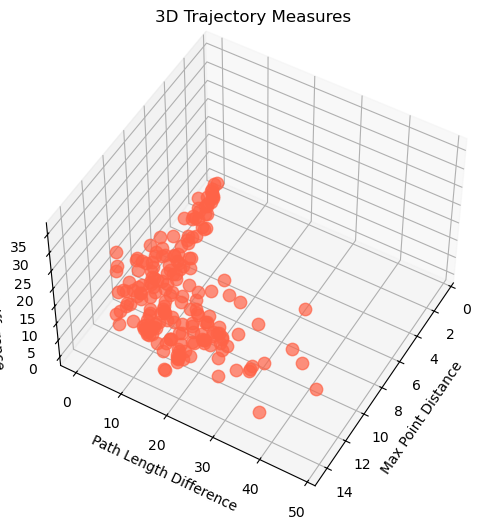

In [198]:
pulse_wid = 5.
pulse_per = 200.

# Time array
time_stop = 200
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

fig = figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')


pulse_amps = linspace(1, 7, 200)

measures_all = list()

for pulse_amp in pulse_amps:
    
    pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2-pulse_wid/2, pulse_wid)
        
    # Simulation
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
                  hmax=0.1)

    trajectory = y_pert[105000:130000, :]
    
    measures = [max_point_distance(trajectory), path_length_difference(trajectory), shape_difference(trajectory)]

    measures_all.append(measures)

for meas in measures_all:

    ax.scatter(*meas, s=80, alpha=0.7, c='tomato', label=f'T {index+1}');
 
ax.set_xlabel('Max Point Distance')
ax.set_ylabel('Path Length Difference')
ax.set_zlabel('Shape Difference')
ax.set_title('3D Trajectory Measures')
# ax.legend()

ax.view_init(50, 30)

# plt.show()

# 2. With grouping (if you know which trajectories belong together)
# group_labels = [0, 0, 1, 1, 2, 2]  # group indices
# plot_3d_trajectory_clusters_enhanced(trajectories, group_labels)

# 3. Basic version with labels
# labels = ['Similar', 'Firing', 'Non-firing', 'Mixed']
# plot_3d_trajectory_clusters(trajectories, labels)

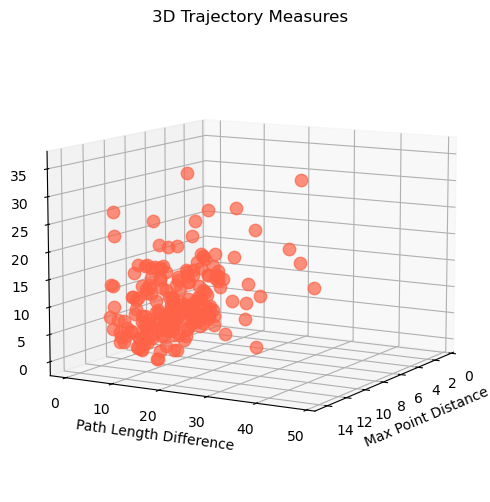

In [200]:
fig = figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')

for meas in measures_all:

    ax.scatter(*meas, s=80, alpha=0.7, c='tomato', label=f'T {index+1}');
 
ax.set_xlabel('Max Point Distance')
ax.set_ylabel('Path Length Difference')
ax.set_zlabel('Shape Difference')
ax.set_title('3D Trajectory Measures')
# ax.legend()

ax.view_init(10, 30)

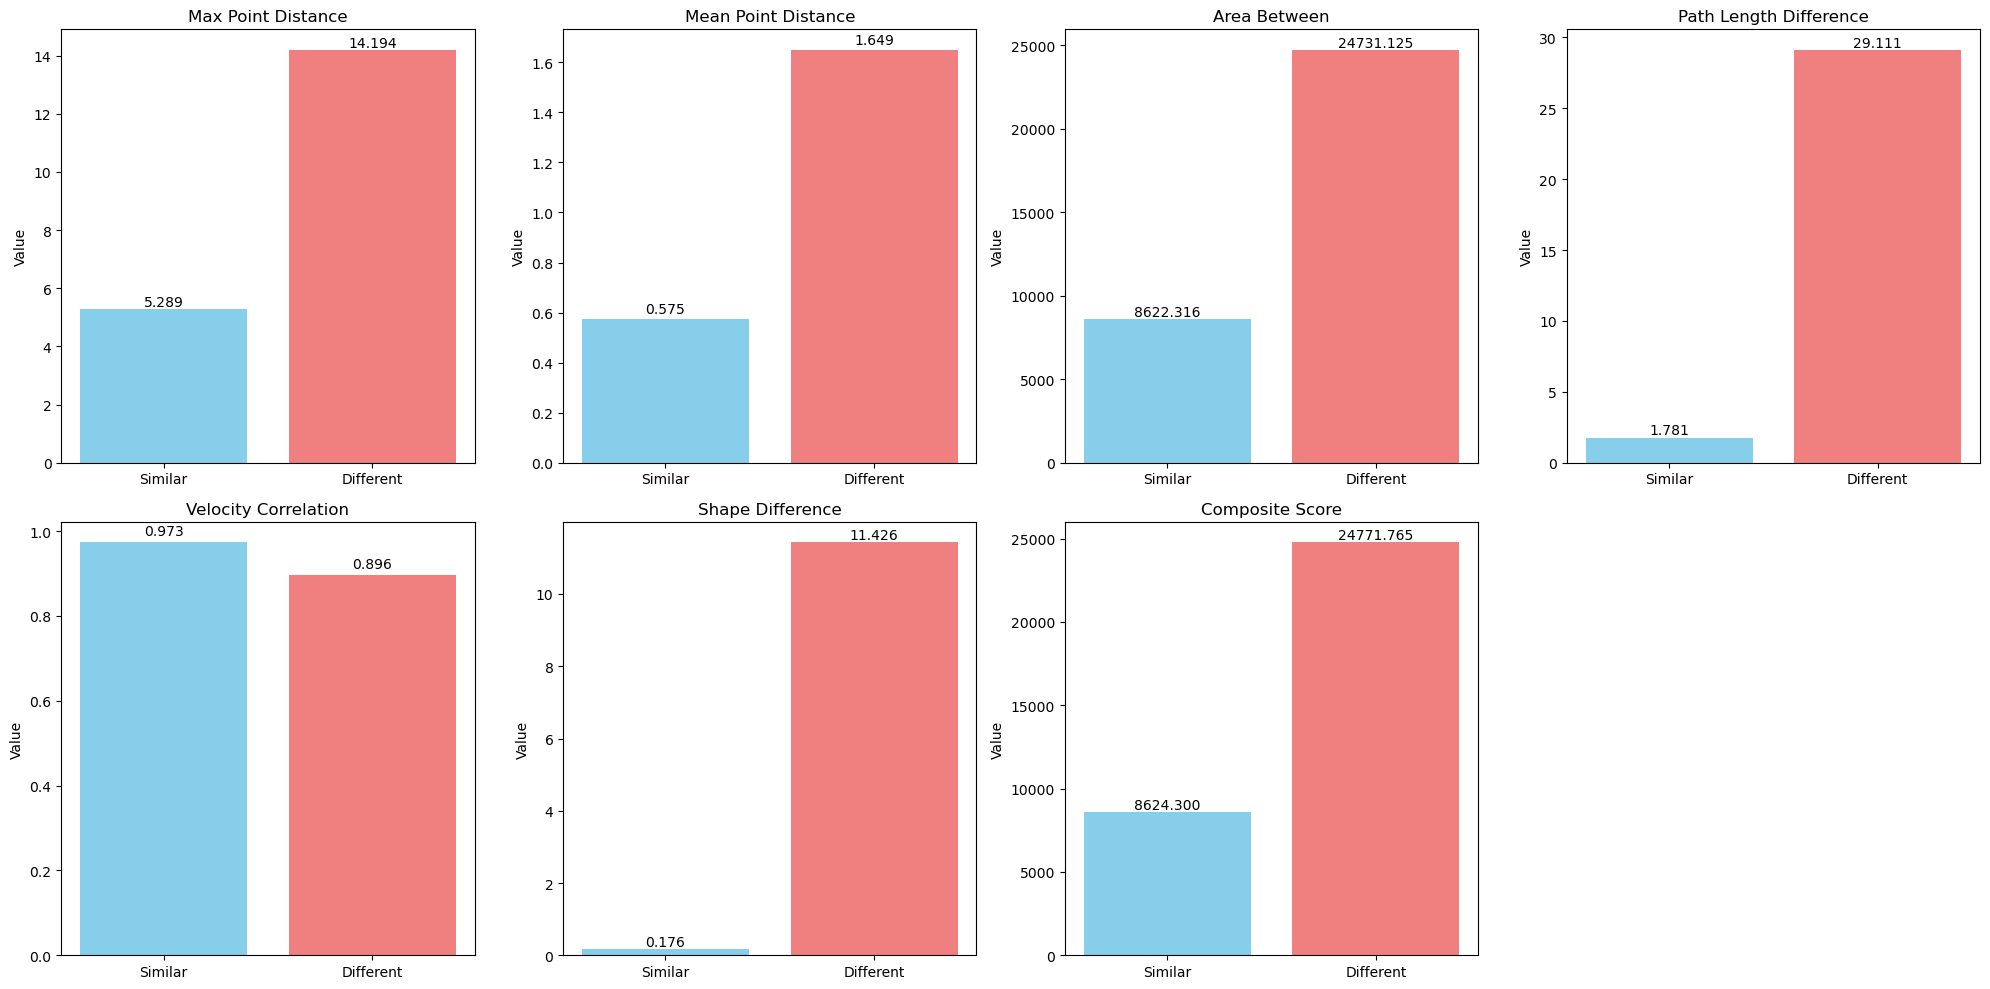

In [150]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory_comparison(results_dict1, results_dict2, labels=['Similar', 'Different']):
    """
    Create bar charts comparing two trajectory analysis results
    """
    # Extract the metrics that are suitable for bar charts
    metrics = ['max_point_distance', 'mean_point_distance', 'area_between', 
               'path_length_difference', 'velocity_correlation', 'shape_difference', 
               'composite_score']
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if i < len(axes):
            values = [results_dict1[metric], results_dict2[metric]]
            bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
            axes[i].set_title(metric.replace('_', ' ').title())
            axes[i].set_ylabel('Value')
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom')
    
    # Remove empty subplots
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Usage:
# results1 = comprehensive_trajectory_analysis(data_similar)
# results2 = comprehensive_trajectory_analysis(data_different)
plot_trajectory_comparison(result_similar, result_different)

In [170]:
result_similar

{'max_point_distance': np.float64(5.289331091709366),
 'mean_point_distance': np.float64(0.5749351955355837),
 'area_between': np.float64(8622.315682854667),
 'path_length_osc1': np.float64(36.908308037977434),
 'path_length_osc2': np.float64(35.12698331057021),
 'path_length_difference': np.float64(1.781324727407224),
 'velocity_correlation': np.float64(0.9730216308729599),
 'shape_difference': np.float64(0.17612182475539645),
 'composite_score': np.float64(8624.300107775958)}

In [131]:
def plot_multiple_trajectory_results(all_results, case_names, metric_subset=None):
    """
    Plot comparison of multiple trajectory cases
    
    Parameters:
    all_results: list of result dictionaries
    case_names: list of case names for labeling
    metric_subset: specific metrics to plot (if None, plots all)
    """
    if metric_subset is None:
        metric_subset = ['max_point_distance', 'mean_point_distance', 'area_between',
                        'path_length_difference', 'velocity_correlation', 
                        'shape_difference', 'composite_score']
    
    n_metrics = len(metric_subset)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_metrics > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_results)))
    
    for i, metric in enumerate(metric_subset):
        if i < len(axes):
            values = [result[metric] for result in all_results]
            
            bars = axes[i].bar(case_names, values, color=colors[:len(values)])
            axes[i].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Value')
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add value labels
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Hide empty subplots
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def plot_radar_chart_comparison(all_results, case_names):
    """
    Create a radar chart for comprehensive comparison
    """
    # Select key metrics for radar chart
    radar_metrics = ['mean_point_distance', 'area_between', 'path_length_difference', 
                    'velocity_correlation', 'shape_difference']
    
    # Normalize values for radar chart (0-1 scale)
    def normalize_values(values):
        min_val = min(values)
        max_val = max(values)
        if max_val == min_val:
            return [0.5] * len(values)
        return [(v - min_val) / (max_val - min_val) for v in values]
    
    # Prepare data
    angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
    
    for i, (results, name) in enumerate(zip(all_results, case_names)):
        values = [results[metric] for metric in radar_metrics]
        normalized_values = normalize_values(values)
        normalized_values += normalized_values[:1]  # Complete the circle
        
        ax.plot(angles, normalized_values, 'o-', linewidth=2, label=name, color=colors[i])
        ax.fill(angles, normalized_values, alpha=0.1, color=colors[i])
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', '\n').title() for m in radar_metrics])
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.set_title('Trajectory Comparison Radar Chart', size=16, fontweight='bold')
    
    plt.show()


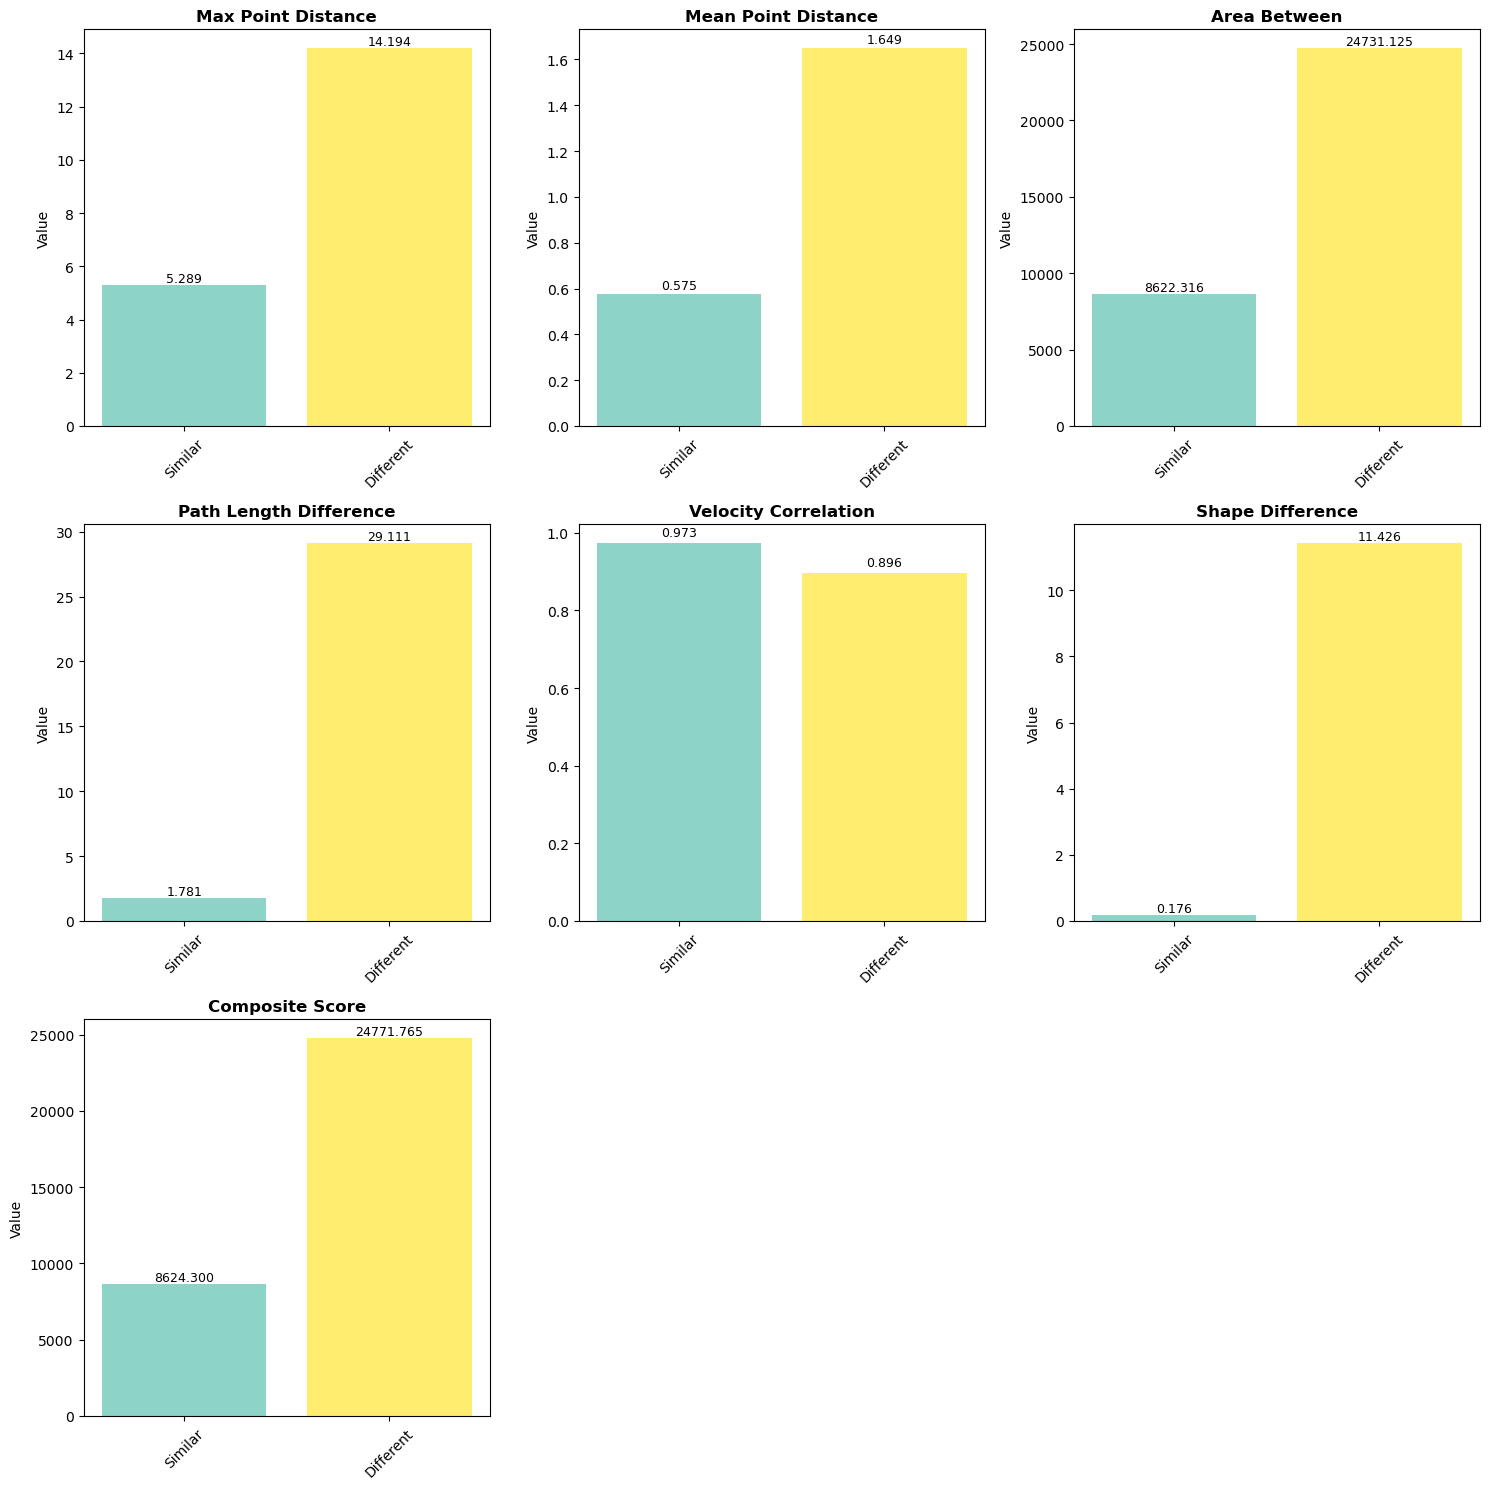

In [132]:
plot_multiple_trajectory_results([result_similar, result_different], ['Similar', 'Different'])

In [136]:
def plot_radar_chart_comparison(all_results, case_names):
    """
    Create a radar chart for comprehensive comparison with better normalization
    """
    # Select key metrics for radar chart
    radar_metrics = ['mean_point_distance', 'area_between', 'path_length_difference', 
                    'velocity_correlation', 'shape_difference']
    
    # Normalize each metric independently to [0,1] range
    normalized_data = []
    
    for results in all_results:
        normalized_case = []
        for metric in radar_metrics:
            # Get all values for this metric across all cases
            all_values = [r[metric] for r in all_results]
            min_val = min(all_values)
            max_val = max(all_values)
            
            # Normalize this specific metric
            if max_val == min_val:
                normalized_value = 0.5  # Middle if all values are the same
            else:
                normalized_value = (results[metric] - min_val) / (max_val - min_val)
            normalized_case.append(normalized_value)
        normalized_data.append(normalized_case)
    
    # Prepare angles for radar chart
    angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
    
    for i, (normalized_values, name) in enumerate(zip(normalized_data, case_names)):
        # Complete the circle for plotting
        plot_values = normalized_values + normalized_values[:1]
        
        ax.plot(angles, plot_values, 'o-', linewidth=2, label=name, color=colors[i])
        ax.fill(angles, plot_values, alpha=0.1, color=colors[i])
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', '\n').title() for m in radar_metrics])
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.set_title('Trajectory Comparison Radar Chart\n(Normalized per metric)', size=16, fontweight='bold')
    
    plt.show()

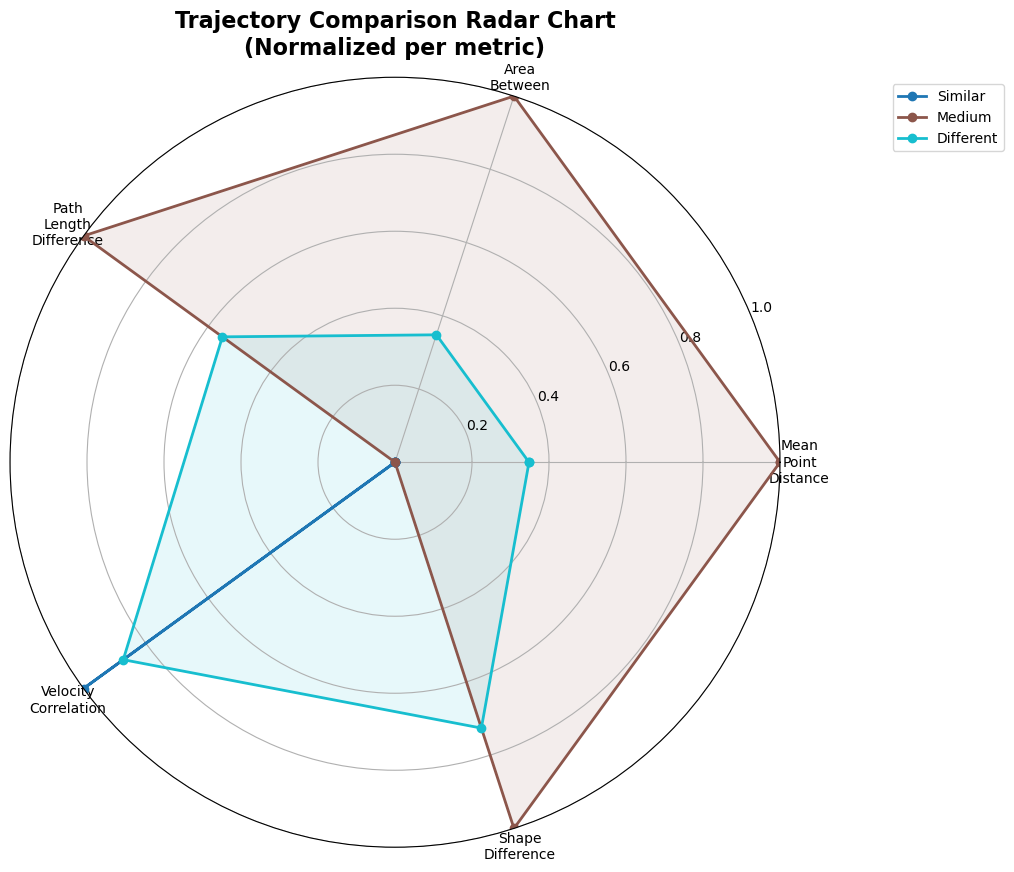

In [137]:
plot_radar_chart_comparison([result_similar, result_medium, result_different], ['Similar', 'Medium', 'Different'])

TRAJECTORY ANALYSIS COMPREHENSIVE REPORT


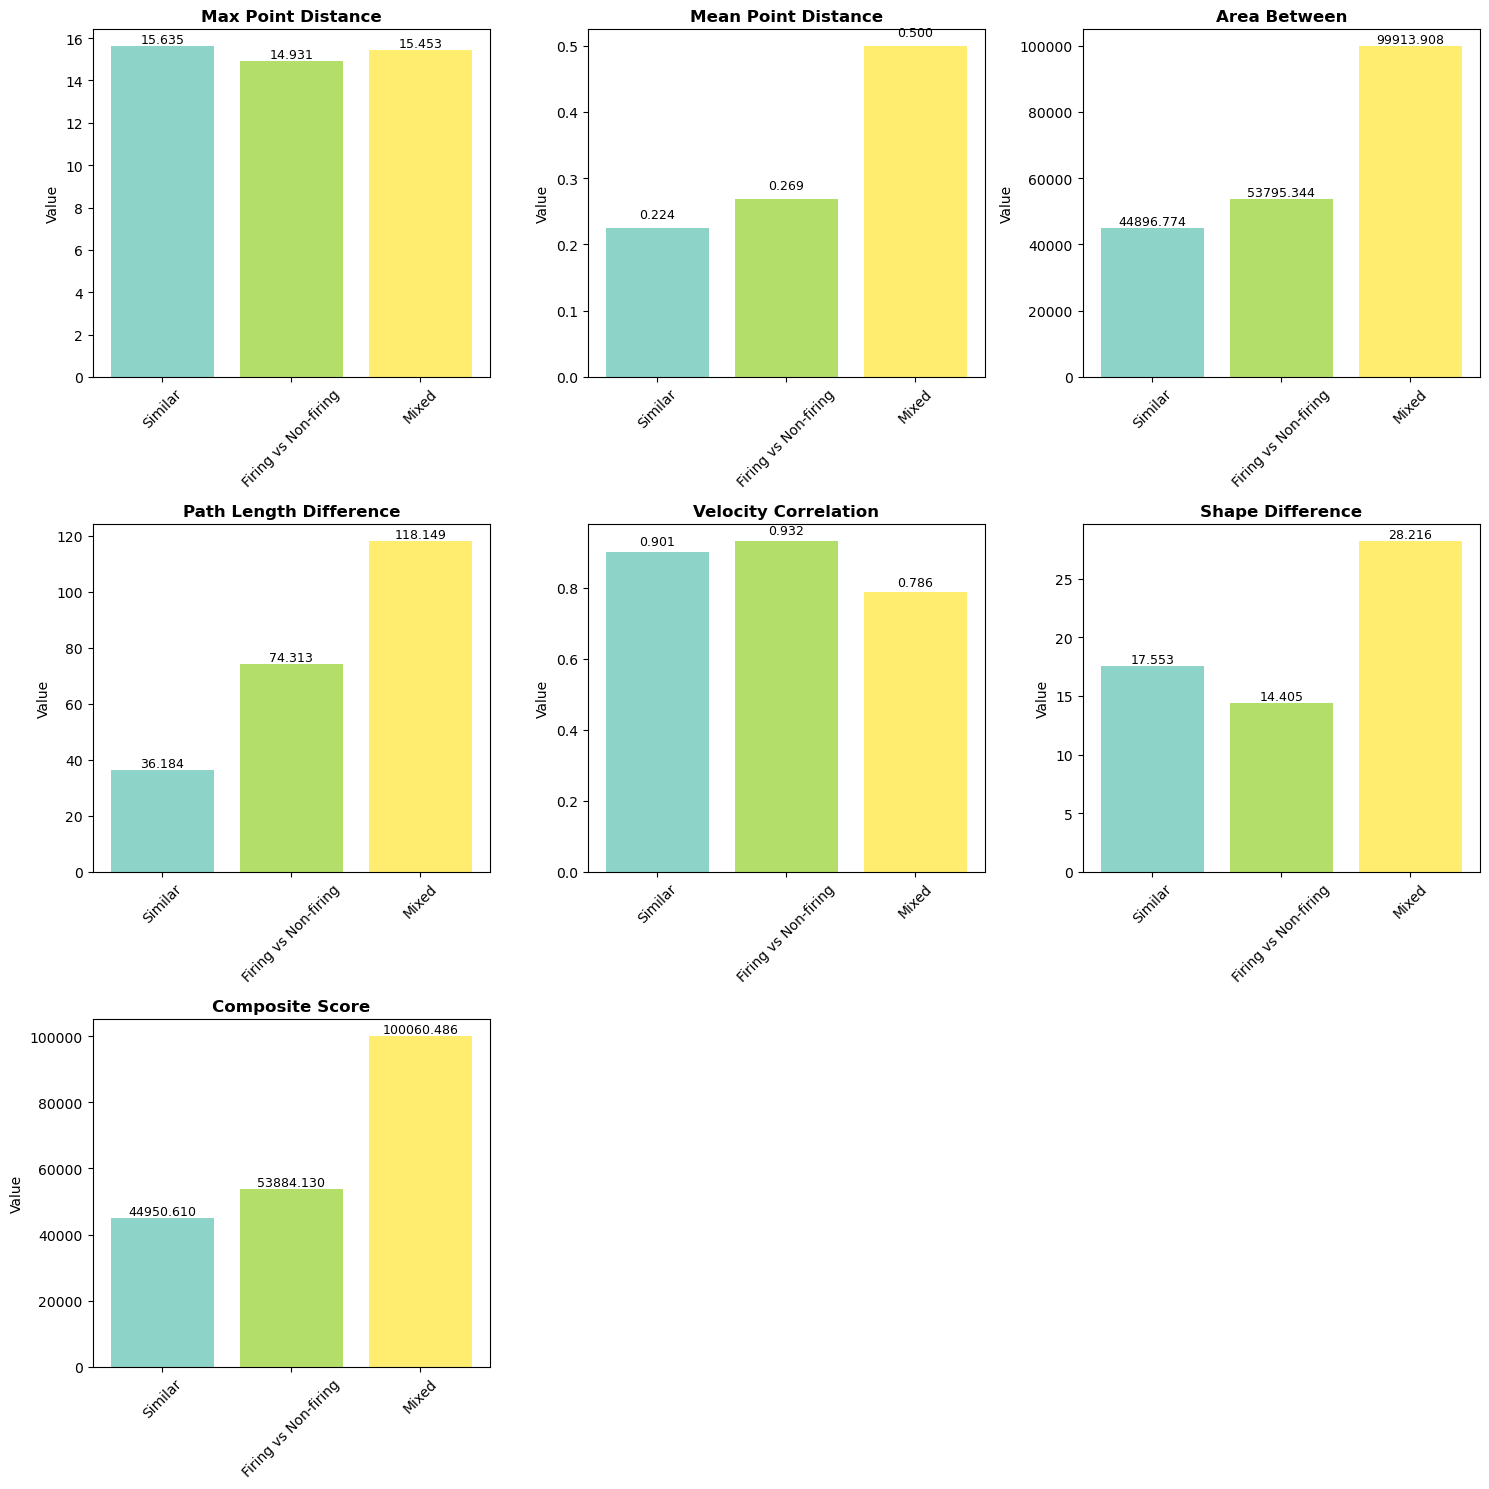

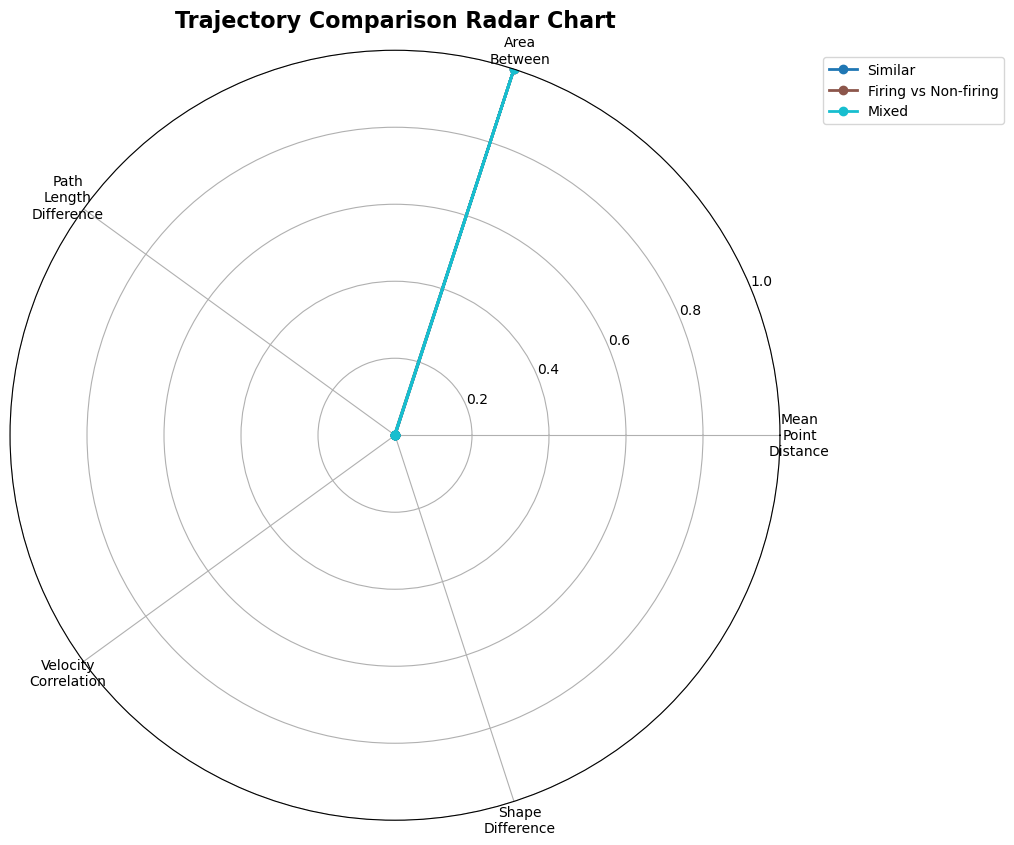

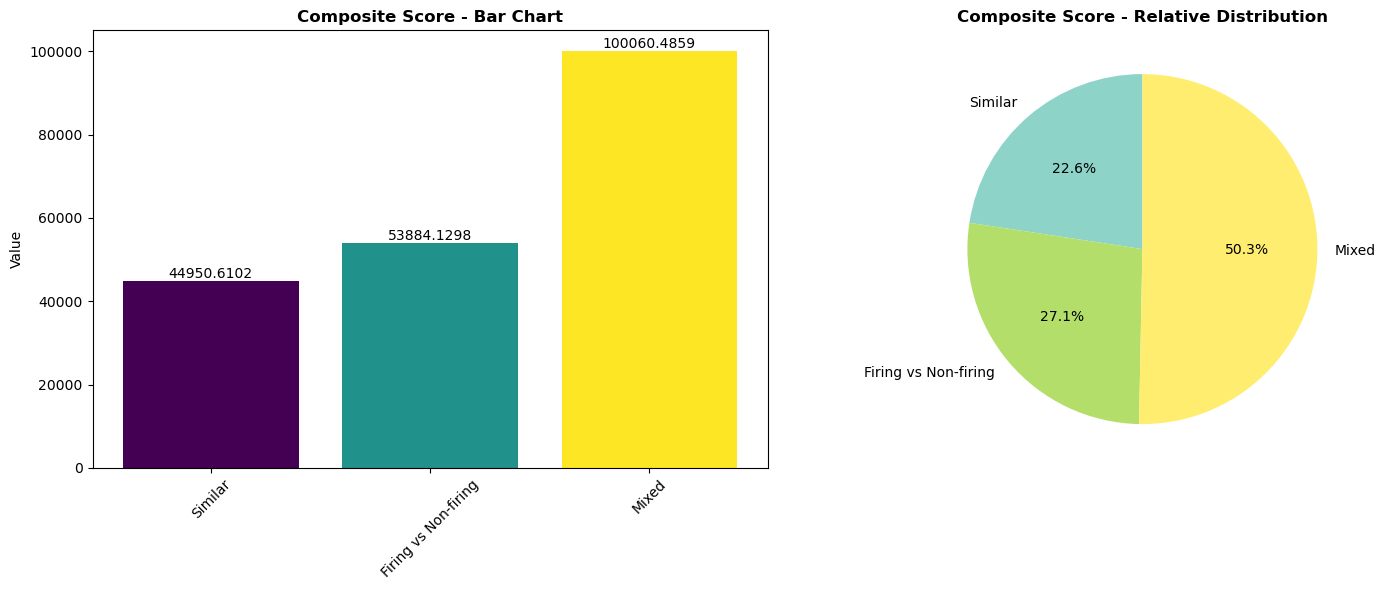


NUMERICAL SUMMARY:
----------------------------------------
Composite Score          : [np.float64(44950.610167408886), np.float64(53884.129750497974), np.float64(100060.48594139144)]
                           Difference: 122.6%
Area Between             : [np.float64(44896.77386521499), np.float64(53795.34365020898), np.float64(99913.90765834558)]
                           Difference: 122.5%
Path Length Difference   : [np.float64(36.18425428682296), np.float64(74.31308945917513), np.float64(118.14883226005064)]
                           Difference: 226.5%
Shape Difference         : [np.float64(17.553080291286538), np.float64(14.404667132026075), np.float64(28.21583063472014)]
                           Difference: 95.9%


In [134]:
def plot_individual_metric_comparison(all_results, case_names, metric_name):
    """
    Create a detailed plot for a specific metric
    """
    values = [result[metric_name] for result in all_results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart
    bars = ax1.bar(case_names, values, color=plt.cm.viridis(np.linspace(0, 1, len(values))))
    ax1.set_title(f'{metric_name.replace("_", " ").title()} - Bar Chart', fontweight='bold')
    ax1.set_ylabel('Value')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom')
    
    # Pie chart showing relative proportions
    ax2.pie(values, labels=case_names, autopct='%1.1f%%', startangle=90,
           colors=plt.cm.Set3(np.linspace(0, 1, len(values))))
    ax2.set_title(f'{metric_name.replace("_", " ").title()} - Relative Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def create_comprehensive_report(all_results, case_names):
    """
    Create a complete visualization report
    """
    print("="*60)
    print("TRAJECTORY ANALYSIS COMPREHENSIVE REPORT")
    print("="*60)
    
    # 1. Basic bar chart comparison
    plot_multiple_trajectory_results(all_results, case_names)
    
    # 2. Radar chart for overall pattern
    plot_radar_chart_comparison(all_results, case_names)
    
    # 3. Individual focus on composite score
    plot_individual_metric_comparison(all_results, case_names, 'composite_score')
    
    # 4. Print numerical summary
    print("\nNUMERICAL SUMMARY:")
    print("-" * 40)
    metrics = ['composite_score', 'area_between', 'path_length_difference', 'shape_difference']
    for metric in metrics:
        values = [result[metric] for result in all_results]
        print(f"{metric.replace('_', ' ').title():<25}: {values}")
        if len(values) > 1:
            diff_percent = ((max(values) - min(values)) / min(values)) * 100
            print(f"{'':<25}  Difference: {diff_percent:.1f}%")

# Complete usage example:
def analyze_and_visualize_multiple_cases(trajectory_data_list, case_names):
    """
    Complete analysis and visualization pipeline
    """
    # Analyze all cases
    all_results = []
    for data in trajectory_data_list:
        results = comprehensive_trajectory_analysis(data)
        all_results.append(results)
    
    # Create comprehensive report
    create_comprehensive_report(all_results, case_names)
    
    return all_results


data_cases = [y_similar, y_different, y_medium]  # your trajectory data
case_names = ['Similar', 'Firing vs Non-firing', 'Mixed']
results = analyze_and_visualize_multiple_cases(data_cases, case_names)

# Pulse Parameter Scan 2D

COMPLETE
 


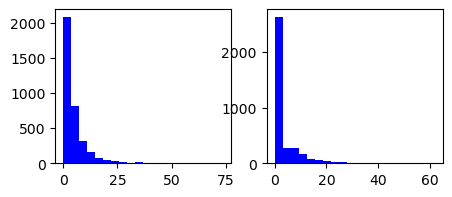

In [67]:
# Initial conditions y_last
y_last = y_ini.copy()

time_stop_pert = 200
sr             = 1000
time           = linspace(start=0, stop=time_stop_pert, num=time_stop_pert*sr)

resolution = 60

pulse_width_min, pulse_width_max = 0.1, 5.1
pulse_ampli_min, pulse_ampli_max = 5, 0.0001

pulse_width = linspace(pulse_width_min, pulse_width_max, resolution)
pulse_ampli = linspace(pulse_ampli_min, pulse_ampli_max, resolution)

pulse_period = 200

results_pert = list()

for pulse in product(pulse_width, pulse_ampli):

    h_ex_p = h_ex_0 + pulse[1]*ss.rect(mod(time, pulse_period)-pulse_period/2+pulse[0]/2, pulse[0])

    y = odeint(func=oscillator, y0=y_last, t=time, args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop_pert, h_ex_p),
              hmax=0.1)


    results_pert.append((sum(y[time_stop_pert*sr//2:, 0] - y_last[0])/sr, 
                         sum(y[time_stop_pert*sr//2:, 2] - y_last[2])/sr
                     ))

results_pert_ex1_matrix = asarray(results_pert)[:, 0].reshape(resolution, resolution)
results_pert_ex2_matrix = asarray(results_pert)[:, 1].reshape(resolution, resolution)

print('COMPLETE')
print(' ')

fig, ax = subplots(ncols=2, figsize=(5, 2))

ax[0].hist(results_pert_ex1_matrix.ravel(), bins=20, color='b');

ax[1].hist(results_pert_ex2_matrix.ravel(), bins=20, color='b');

fig.tight_layout()


'PulsePert_Homoclinic_frac_E=0.2_frac_I=0.12.png'

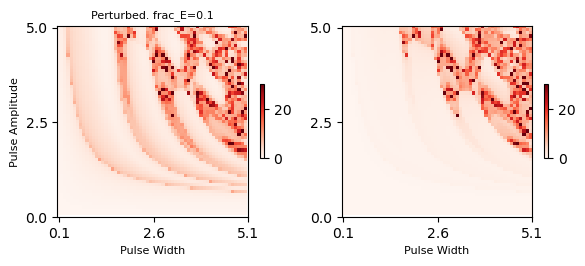

In [68]:
vmin1, vmax1 = 0, 30
vmin2, vmax2 = 0, 30

fig, ax = subplots(figsize=(6, 4), ncols=2)

im1 = ax[0].imshow(results_pert_ex1_matrix.T, cmap='Reds', vmin=vmin1, vmax=vmax1)

ax[0].set_xlabel('Pulse Width', fontsize=8)
ax[0].set_ylabel('Pulse Amplitude', fontsize=8)
ax[0].set_xticks(linspace(0, resolution, 3))
ax[0].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3),1))
ax[0].set_yticks(linspace(0, resolution, 3))
ax[0].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))
ax[0].set_title('Perturbed. frac_E=0.1', fontsize=8)



im2 = ax[1].imshow(results_pert_ex2_matrix.T, cmap='Reds', vmin=vmin2, vmax=vmax2)

ax[1].set_xlabel('Pulse Width', fontsize=8)
# ax[1].set_ylabel('Pulse Amplitude', fontsize=8)
ax[1].set_xticks(linspace(0, resolution, 3))
ax[1].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3), 1))
ax[1].set_yticks(linspace(0, resolution, 3))
ax[1].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))


fig.colorbar(im1, ax=ax[0], shrink=0.2);
fig.colorbar(im2, ax=ax[1], shrink=0.2);

fig.tight_layout()

if pars[1] == 1.5:
    
    title_chars = 'Figs/N=1/Fig_2Cb_PulsePert_SNIC.png'
    
elif pars[1] == 2.5:

    title_chars = 'PulsePert_Homoclinic_frac_E=' + str(frac_E) + '_frac_I=' + str(frac_I) +'.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

# 2 and 3 D Parameter Scan

Performing 3D parameter scan...


h_ex_1 progress: 100%|██████████| 15/15 [02:42<00:00, 10.84s/it]

Scan completed!


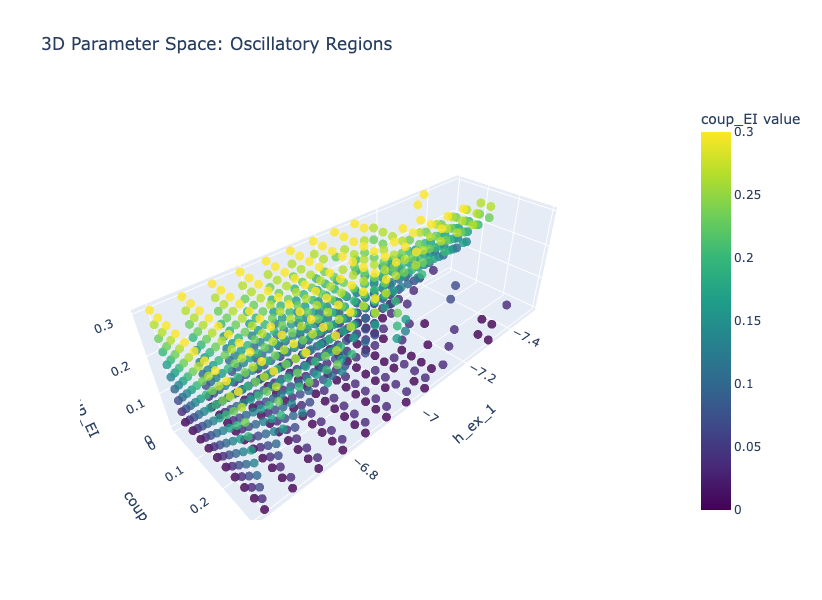

IndexError: index 11 is out of bounds for axis 2 with size 10

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from tqdm import tqdm


def detect_oscillation(solution, threshold_peaks=3, prominence_factor=0.01):
    """
    Detect if the solution exhibits oscillations by looking for multiple peaks
    in the Ex variable after transients have decayed.
    """
    # Use the second half of the time series to avoid transients
    t = solution.t
    Ex = solution.y[0]
    
    # Focus on the second half to avoid initial transients
    start_idx = len(t) // 2
    t_steady = t[start_idx:]
    Ex_steady = Ex[start_idx:]
    
    if len(Ex_steady) < 50:  # Not enough points
        return False
    
    # Calculate prominence for peak detection
    Ex_range = np.max(Ex_steady) - np.min(Ex_steady)
    prominence = Ex_range * prominence_factor

    # Find peaks
    peaks, _ = find_peaks(Ex_steady, distance=20, prominence=prominence)
    
    # Minimum number of peaks
    return len(peaks) >= threshold_peaks


def analyze_parameter_point(h_ex_1_val, coup_EE_val, coup_EI_val, other_params, t_span=(0, 20)):
    """Analyze a single point in parameter space"""
    try:
        solution = solve_ivp(fun=oscillator, t_span=t_span, y0=y_ini,
            args=(N, h_ex_1_val,  h_in_0, other_params, coup_EE_val, coup_EI_val, sr, t_span[1], pulse), 
            method='BDF', max_step=0.1, rtol=1e-6
        )

        # y0 = solution.y[:, -1]
        
        if solution.success:
            return detect_oscillation(solution)
        else:
            return False
    except:
        return False

# Fixed parameters
other_params = (1, 2.5, 10, 0, 5, 10) # Homoclinic

frac_E, frac_I = 0.1, 0.0 # < 1. 0, 0 means no coupling

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
y_ini = rng.uniform(size=2*N)

# 3D Parameter ranges to explore
h_ex_1_range  = np.linspace(-7.5, -6.6, 15)      
coup_EE_range = np.linspace(0.0, 0.3, 10)    
coup_EI_range = np.linspace(0.0, 0.3, 10)     


# Create the 3D parameter space grid
oscillation_grid_3d = np.zeros((len(h_ex_1_range), len(coup_EE_range), len(coup_EI_range)))

# 3D parameter scan
print("Performing 3D parameter scan...")
total_points = len(h_ex_1_range) * len(coup_EE_range) * len(coup_EI_range)
point_count = 0

for i, h_ex_1_val in enumerate(tqdm(h_ex_1_range, desc="h_ex_1 progress")):
    for j, coup_EE_val in enumerate(coup_EE_range):
        for k, coup_EI_val in enumerate(coup_EI_range):
            if analyze_parameter_point(h_ex_1_val, coup_EE_val, coup_EI_val, other_params):
                oscillation_grid_3d[i, j, k] = 1
    
print("Scan completed!")


# Create interactive 3D plot
def create_3d_oscillation_plot(oscillation_grid_3d, h_ex_1_range, coup_EE_range, coup_EI_range):
    """Create an interactive 3D scatter plot of oscillatory regions"""
    
    # Get coordinates of oscillatory points
    oscillatory_points = np.where(oscillation_grid_3d == 1)
    
    if len(oscillatory_points[0]) == 0:
        print("No oscillatory regions found in the parameter space!")
        return
    
    h_ex_osc    = h_ex_1_range[oscillatory_points[0]]
    coup_EE_osc = coup_EE_range[oscillatory_points[1]] 
    coup_EI_osc = coup_EI_range[oscillatory_points[2]]
    
    # Create 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=h_ex_osc,
        y=coup_EE_osc, 
        z=coup_EI_osc,
        mode='markers',
        marker=dict(
            size=5,
            color=coup_EI_osc,  # Color by q value
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="coup_EI value")
        ),
        name='Oscillatory regions',
        hovertemplate=
        "<b>k_max:</b> %{x:.2f}<br>" +
        "<b>a1:</b> %{y:.2f}<br>" +
        "<b>q:</b> %{z:.2f}<br>" +
        "<extra></extra>"
    )])
    
    fig.update_layout(
        title='3D Parameter Space: Oscillatory Regions',
        scene=dict(
            xaxis_title='h_ex_1',
            yaxis_title='coup_EE',
            zaxis_title='coup_EI',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=600
    )
    
    return fig

# Create the interactive plot
fig_3d = create_3d_oscillation_plot(oscillation_grid_3d, h_ex_1_range, coup_EE_range, coup_EI_range)
fig_3d.show()

# Additional: Create 2D slices for different q values
def create_2d_slices(oscillation_grid_3d, h_ex_1_range, coup_EE_range, coup_EI_range, num_slices=6):
    """Create 2D slices of the 3D parameter space"""
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=[f'q = {h_ex_1_val:.2f}' for h_ex_1_val in h_ex_1_range[np.linspace(0, len(h_ex_1_range)-1, num_slices, dtype=int)]]
    )
    
    slice_indices = np.linspace(0, len(h_ex_1_range)-1, num_slices, dtype=int)
    
    for idx, q_idx in enumerate(slice_indices):
        row = idx // 3 + 1
        col = idx % 3 + 1
        
        # Create heatmap for this q slice
        heatmap = go.Heatmap(
            z=oscillation_grid_3d[:, :, q_idx],
            x=coup_EE_range,
            y=coup_EI_range,
            colorscale=['white', 'red'],
            showscale=False
        )
        
        fig.add_trace(heatmap, row=row, col=col)
        
        if row == 2:
            fig.update_xaxes(title_text="coup_EE", row=row, col=col)
        if col == 1:
            fig.update_yaxes(title_text="h_ex_1", row=row, col=col)
    
    fig.update_layout(
        title_text="2D Slices of 3D Parameter Space (Red = Oscillations)",
        height=600
    )
    
    return fig

# Create 2D slice visualization
fig_slices = create_2d_slices(oscillation_grid_3d, h_ex_1_range, coup_EE_range, coup_EI_range)
fig_slices.show()

# Save the 3D data for later use
np.save('Data/oscillation_grid_3d.npy', oscillation_grid_3d)
np.save('Data/h_ex_1_range.npy', h_ex_1_range)
np.save('Data/coup_EE_range.npy', coup_EE_range) 
np.save('Data/coup_EI_range.npy', coup_EI_range)

print("3D data saved to files")

# Periodic Pulse Perturbation

In [112]:
h_ex_0 = -7.06

# frac_E, frac_I = 0.5, 0.0 # < 1. 0 means no coupling

pulse_wid = 3.
pulse_amp = 2.2
pulse_per = 170

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
# y_in = rng.uniform(size=2*N)

# Time array
time_stop = 170
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2-pulse_wid/2, pulse_wid)
    
# Simulation
y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
              args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
              hmax=0.1)

# Resetting of initial conditions
# y_in = y_pert[-1, :]

# Show final values of all variables
print('End of run:', around(y_pert[-1,:],2))
print('')


End of run: [ -1.6  -12.73   0.84  -0.54]



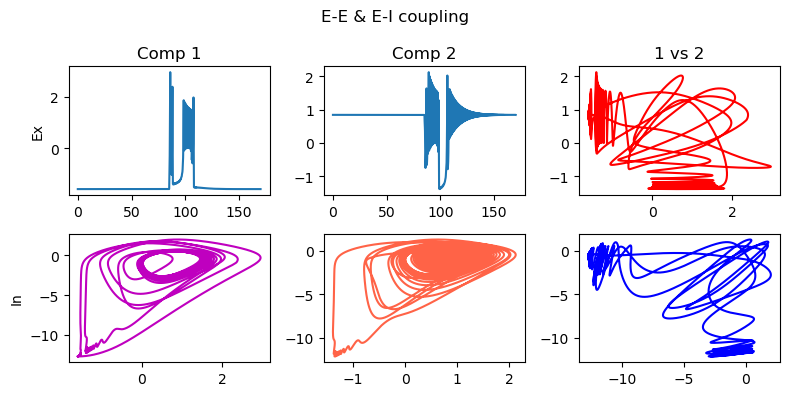

In [113]:
fig, ax = subplots(ncols=3, nrows=2, figsize=(8, 4))

ax[0, 0].plot(time, y_pert[:,0]);
ax[0, 1].plot(time, y_pert[:,2]);

ax[1, 0].plot(y_pert[:,0], y_pert[:,1], color='m');
ax[1, 1].plot(y_pert[:,2], y_pert[:,3], color='tomato');

ax[0, 2].plot(y_pert[:,0], y_pert[:,2], color='r');
ax[1, 2].plot(y_pert[:,1], y_pert[:,3], color='b');


ax[0, 0].set_title('Comp 1')
ax[0, 1].set_title('Comp 2')
ax[0, 2].set_title('1 vs 2')

ax[0, 0].set_ylabel('Ex')
ax[1, 0].set_ylabel('In')


if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I coupling'
    fig.suptitle(chars)

elif frac_E > 0 and frac_I > 0:
    
    chars = 'E-E & E-I coupling'
    fig.suptitle(chars)

else:
    
    chars = 'No coupling'
    fig.suptitle(chars)
    
fig.tight_layout()

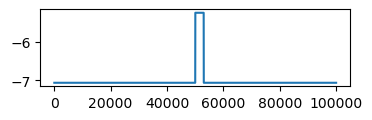

In [91]:
fig, ax = subplots(figsize=(4, 1))

ax.plot(pert);

In [26]:
# Bifurcation parameter set
steps = 20
freq_min, freq_max = 0.1, 2
freq_set = linspace(freq_min, freq_max, steps)

# Time array
time_stop = 100
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

pulse_wid = 1.
pulse_amp = 0.25

results = list()

    
results_min_f      = dict()
results_min_inds_f = dict()
results_max_f      = dict()
results_max_inds_f = dict()

# Simulation "forward"
for freq in freq_set:
    
    pert = h_ex_0 + pulse_amp*ss.rect(mod(time, 1/freq)-(1/freq)/2-pulse_wid/2, pulse_wid)

    y_pert = odeint(func=oscillator, y0=y_in, t=time, 
                    args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
                    hmax=0.1)

    for num, series in enumerate(y_pert[rows//2:,::2].T):
                
        if var(series) < 0.0001:
    
            if num not in results_min_f:
                
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
               
            else:
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)    

            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
               
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    

        else:
            
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_min_f:

                results_min_f[num]      = [y_f_mins]
                results_min_inds_f[num] = [y_f_min_inds]
                
                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]

            else:

                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)
                
                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)

        # if par != par_set[-1]:
            
        #     y_in = y_pert[-1, :]

    results.append((results_min_f, results_max_f))

print('')
print('Scan complete!')
print('')



Scan complete!



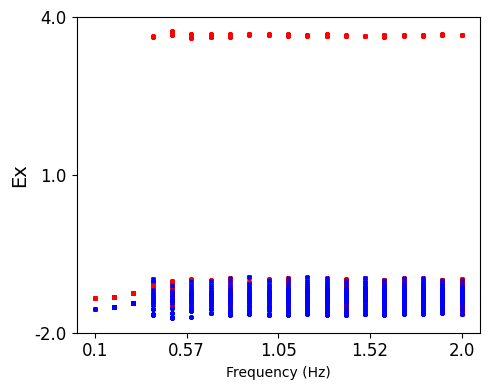

In [28]:
# Plot
fig, ax = plot_bifdiagram_scan(results, freq_set)

    
ax.set_xlabel('Frequency (Hz)', fontsize=10);


fig.tight_layout()

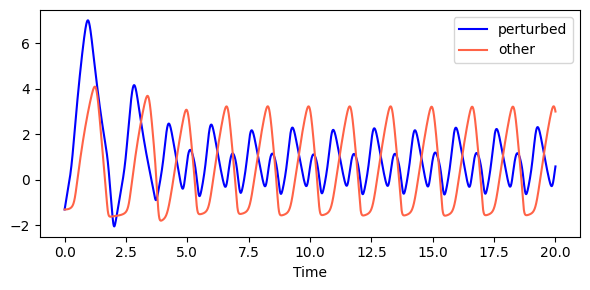

In [30]:
# Time array
time_stop = 20
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

freq       = 0.5

pulse      = pulse_amp*ss.rect(mod(time, 1/freq)-(1/freq)/2-pulse_wid/2, pulse_wid)

fig, ax = subplots(figsize=(6, 3))

y_pert = odeint(func=oscillator, y0=y_in, t=time, 
                args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
                hmax=0.1)

ax.plot(time, y_pert[:, 0], c='b',      label='perturbed')
ax.plot(time, y_pert[:, 2], c='tomato', label='other')
ax.legend()

ax.set_xlabel('Time');

fig.tight_layout()


# Pulse Perturbation 2D Parameter Scan

COMPLETE
 


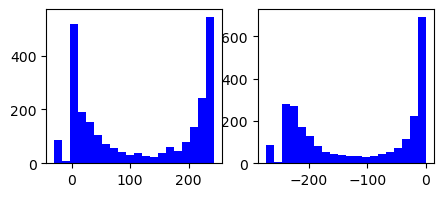

In [104]:
# Initial conditions y_last
y_last = y_ini.copy()

time_stop_pert = 200
sr             = 1000
time           = linspace(start=0, stop=time_stop_pert, num=time_stop_pert*sr)

resolution = 50

pulse_width_min, pulse_width_max = 0.1, 4.1
pulse_ampli_min, pulse_ampli_max = 4, 0.0001

pulse_width = linspace(pulse_width_min, pulse_width_max, resolution)
pulse_ampli = linspace(pulse_ampli_min, pulse_ampli_max, resolution)

pulse_period = 200

results_pert = list()

for pulse in product(pulse_width, pulse_ampli):

    h_ex_p = h_ex_0 + pulse[1]*ss.rect(mod(time, pulse_period)-pulse_period/2+pulse[0]/2, pulse[0])

    y = odeint(func=oscillator, y0=y_last, t=time, args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop_pert, h_ex_p),
              hmax=0.1)


    results_pert.append((sum(y[time_stop_pert*sr//2:, 0] - y_last[0])/sr, 
                         sum(y[time_stop_pert*sr//2:, 2] - y_last[2])/sr
                     ))

results_pert_ex1_matrix = asarray(results_pert)[:, 0].reshape(resolution, resolution)
results_pert_ex2_matrix = asarray(results_pert)[:, 1].reshape(resolution, resolution)

print('COMPLETE')
print(' ')

fig, ax = subplots(ncols=2, figsize=(5, 2))

ax[0].hist(results_pert_ex1_matrix.ravel(), bins=20, color='b');

ax[1].hist(results_pert_ex2_matrix.ravel(), bins=20, color='b');


'PulsePert_Homoclinic_frac_E=0.1_frac_I=0.3.png'

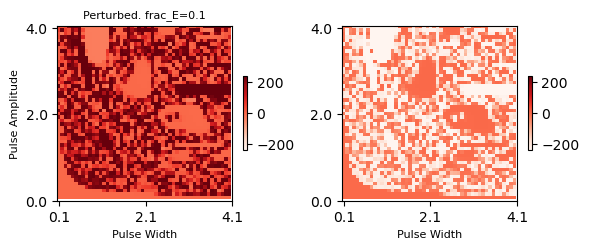

In [105]:
vmin, vmax = -240, 240

fig, ax = subplots(figsize=(6, 4), ncols=2)

im1 = ax[0].imshow(results_pert_ex1_matrix.T, cmap='Reds', vmin=vmin, vmax=vmax)

ax[0].set_xlabel('Pulse Width', fontsize=8)
ax[0].set_ylabel('Pulse Amplitude', fontsize=8)
ax[0].set_xticks(linspace(0, resolution, 3))
ax[0].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3),1))
ax[0].set_yticks(linspace(0, resolution, 3))
ax[0].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))
ax[0].set_title('Perturbed. frac_E=0.1', fontsize=8)


vmin, vmax = -240, 240

im2 = ax[1].imshow(results_pert_ex2_matrix.T, cmap='Reds', vmin=vmin, vmax=vmax)

ax[1].set_xlabel('Pulse Width', fontsize=8)
# ax[1].set_ylabel('Pulse Amplitude', fontsize=8)
ax[1].set_xticks(linspace(0, resolution, 3))
ax[1].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3), 1))
ax[1].set_yticks(linspace(0, resolution, 3))
ax[1].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))


fig.colorbar(im1, ax=ax[0], shrink=0.2);
fig.colorbar(im2, ax=ax[1], shrink=0.2);

fig.tight_layout()

if pars[1] == 1.5:
    
    title_chars = 'Figs/N=1/Fig_2Cb_PulsePert_SNIC.png'
    
elif pars[1] == 2.5:

    title_chars = 'PulsePert_Homoclinic_frac_E=' + str(frac_E) + '_frac_I=' + str(frac_I) +'.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

'Figs/N=1/Fig_2Ca_PulsePert_Homoclinic.png'

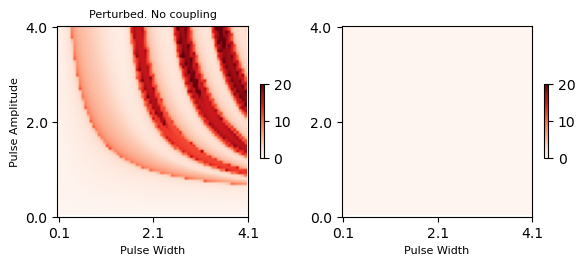

In [36]:
vmin, vmax = 0, 20

fig, ax = subplots(figsize=(6, 4), ncols=2)

im1 = ax[0].imshow(results_pert_ex1_matrix.T, cmap='Reds', vmin=vmin, vmax=vmax)

ax[0].set_xlabel('Pulse Width', fontsize=8)
ax[0].set_ylabel('Pulse Amplitude', fontsize=8)
ax[0].set_xticks(linspace(0, resolution, 3))
ax[0].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3),1))
ax[0].set_yticks(linspace(0, resolution, 3))
ax[0].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))
ax[0].set_title('Perturbed. No coupling', fontsize=8)


im2 = ax[1].imshow(results_pert_ex2_matrix.T, cmap='Reds', vmin=vmin, vmax=vmax)

ax[1].set_xlabel('Pulse Width', fontsize=8)
# ax[1].set_ylabel('Pulse Amplitude', fontsize=8)
ax[1].set_xticks(linspace(0, resolution, 3))
ax[1].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3), 1))
ax[1].set_yticks(linspace(0, resolution, 3))
ax[1].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))


fig.colorbar(im1, ax=ax[0], shrink=0.2);
fig.colorbar(im2, ax=ax[1], shrink=0.2);

fig.tight_layout()

if pars[1] == 1.5:
    
    title_chars = 'Figs/N=1/Fig_2Cb_PulsePert_SNIC.png'
    
elif pars[1] == 2.5:

    title_chars = 'PulsePert_Homoclinic_frac_E=0.0.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

# Test Code

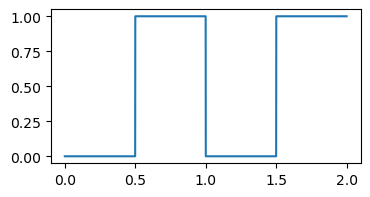

In [18]:
pulse_wid = 0.5
pulse_amp = 1.0

freq = 1

pulse_per = 1/freq
# pulse     = pulse_amp*ss.rect(mod(time, pulse_per)-pulse_per/2+pulse_wid/2, pulse_wid)
pulse     = pulse_amp*ss.rect(mod(time, pulse_per)-pulse_per/2-pulse_wid/2, pulse_wid)

fig, ax = subplots(figsize=(4, 2))

ax.plot(time[:2000], pulse[:2000]);